# Fonction for H&E Image Normalization

At the begining of the project we wanted to normalized H&E images. However, the histopathologist told us that usually images aren't normalized.

We pursued the project with raw images, but the function created in this notebook is functional. 

# 1. Import packages

pip install opencv-python

In [1]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

# 2. Import Image

In [2]:
image_name = "PanCN_AVD_79MZ_0594_C3"

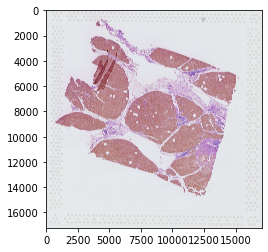

In [3]:
img=cv2.imread('./input_images/PanCN_AVD_79MZ_0594_C3.jpg', 1) # insert the image 
plt.imshow(img)
plt.show()

In [5]:
# save in output files
sevenbg_output_path = f"/sbgenomics/output-files/data/normalized_images_hne/{image_name}"
os.makedirs(sevenbg_output_path, exist_ok=True)

# save in workspace
output_path = f"./normalized_images_hne/{image_name}"
os.makedirs(output_path, exist_ok=True)


# 3. Function definition

In [2]:
def normalization_hne (img, output_path, sevenbg_output_path) :
    """Normalized raw H&E image

    Parameters
    ----------
    img : image to normalized
    
    output_path : string
        path to save image in workspace
    sevenbg_output_path : string
        path to save image in seven bridges
    """
    Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
    alpha = 1  # As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
    beta = 0.15
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    maxCRef = np.array([1.9705, 1.0308])

    # extract the height, width and num of channels of image
    h, w, c = img.shape

    # reshape image to multiple rows and 3 columns.
    # Num of rows depends on the image size (wxh)
    img = img.reshape((-1,3))

    # calculate optical density
    # OD = −log10(I)  
    # OD = -np.log10(img+0.004)  #Use this when reading images with skimage
    # Adding 0.004 just to avoid log of zero. 

    OD = -np.log10((img.astype(np.float64)+1)/Io)

    ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
    #Check by printing ODhat.min()

    ############# Step 3: Calculate SVD on the OD tuples ######################
    #Estimate covariance matrix of ODhat (transposed) and then compute eigen values & eigenvectors.
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


    ######## Step 4: Create plane from the SVD directions with two largest values ######
    #project on the plane spanned by the eigenvectors corresponding to the two largest eigenvalues    
    That = ODhat.dot(eigvecs[:,1:3]) #Dot product

    ############### Step 5: Project data onto the plane, and normalize to unit length ###########
    ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
    #find the min and max vectors and project back to OD space
    phi = np.arctan2(That[:,1],That[:,0])

    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100-alpha)

    vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
    vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)


    # a heuristic to make the vector corresponding to hematoxylin first and the  one corresponding to eosin second
    if vMin[0] > vMax[0]:    
        HE = np.array((vMin[:,0], vMax[:,0])).T

    else:
        HE = np.array((vMax[:,0], vMin[:,0])).T

    # rows correspond to channels (RGB), columns to OD values
    Y = np.reshape(OD, (-1, 3)).T

    # determine concentrations of the individual stains
    C = np.linalg.lstsq(HE,Y, rcond=None)[0]

    # normalize stain concentrations
    maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
    tmp = np.divide(maxC,maxCRef)
    C2 = np.divide(C,tmp[:, np.newaxis])

    ###### Step 8: Convert extreme values back to OD space
    # recreate the normalized image using reference mixing matrix 

    Inorm = np.multiply(Io, np.exp(-HERef.dot(C2)))
    Inorm[Inorm>255] = 254
    Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)  

    H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
    H[H>255] = 254
    H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

    E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
    E[E>255] = 254
    E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

    # save in workspace
    plt.imsave(f"{output_path}/{image_name}_normalized.jpg", Inorm)
    plt.imsave(f"{output_path}/{image_name}_separated_H.jpg", H)
    plt.imsave(f"{output_path}/{image_name}_separated_E.jpg", E)
    
    # save in output filels
    plt.imsave(f"{sevenbg_output_path}/{image_name}_normalized.jpg", Inorm)
    plt.imsave(f"{sevenbg_output_path}/{image_name}_separated_H.jpg", H)
    plt.imsave(f"{sevenbg_output_path}/{image_name}_separated_E.jpg", E)

# 4. Normalize image

In [7]:
normalization_hne(img)